In [1]:
!pip install torch torchvision torchaudio
!pip install opencv-python-headless numpy scikit-image torchmetrics ptflops
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchmetrics.classification import JaccardIndex
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from sklearn.model_selection import train_test_split
import torchvision.models as models
from tqdm import tqdm

In [3]:
# Custom dataset for Chest CT Segmentation
class ChestCTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, start_idx, end_idx, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            mask_dir (str): Directory containing masks.
            start_idx (int): Start index for selecting images.
            end_idx (int): End index (exclusive).
            transform (callable, optional): Optional transform to be applied.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Get all files and sort
        image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.nii'))])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.nii'))])
        print(f"Debug: Total image files found: {len(image_files)}")
        print(f"Debug: Total mask files found: {len(mask_files)}")
        #print(f"Debug: Sample image files: {image_files[:5]}")
        #print(f"Debug: Sample mask files: {mask_files[:5]}")

        def get_base_id(filename):
            name = os.path.splitext(filename)[0]  # Remove file extension
        
            if 'mask' in name.lower():
                # Convert mask filename like ID00109637202210454292264_mask_156
                # into base ID: ID00109637202210454292264_156
                parts = name.split('_')
                try:
                    mask_idx = parts.index('mask')
                    base = '_'.join(parts[:mask_idx] + [parts[mask_idx + 1]])
                except (ValueError, IndexError):
                    # Fallback in case of unexpected format
                    base = name
            else:
                # Image file, just remove extension
                base = name
            # print(f"Debug: Processing {filename}, base ID: {base}")
            return base

        image_bases = {get_base_id(f): f for f in image_files}
        mask_bases = {get_base_id(f): f for f in mask_files}
        #print(f"Debug: Number of unique image base IDs: {len(image_bases)}")
        #print(f"Debug: Number of unique mask base IDs: {len(mask_bases)}")
        #print(f"Debug: Sample image bases: {list(image_bases.keys())[:5]}")
        #print(f"Debug: Sample mask bases: {list(mask_bases.keys())[:5]}")

        # Find common base IDs
        common_bases = set(image_bases.keys()).intersection(mask_bases.keys())
        self.common_image_files = [image_bases[base] for base in common_bases]
        self.common_mask_files = [mask_bases[base] for base in common_bases]
        #print(f"Debug: Number of common base IDs: {len(common_bases)}")
        #print(f"Debug: Sample common base IDs: {list(common_bases)[:5] if common_bases else 'None'}")
        print(f"Total common image-mask pairs: {len(self.common_image_files)}")

        # Sort common files to maintain order
        self.common_image_files.sort()
        self.common_mask_files.sort()

        # Select range based on common files
        total_common = len(self.common_image_files)
        if end_idx > total_common:
            print(f"Warning: Requested end_idx ({end_idx}) exceeds total common files ({total_common}). Adjusting to {total_common}")
            end_idx = total_common
        if start_idx >= end_idx:
            raise ValueError(f"start_idx ({start_idx}) must be less than end_idx ({end_idx})")
        if start_idx < 0:
            raise ValueError(f"start_idx ({start_idx}) must be non-negative")

        self.image_filenames = self.common_image_files[start_idx:end_idx]
        self.mask_filenames = self.common_mask_files[start_idx:end_idx]

        print(f"Dataset loaded: {len(self.image_filenames)} images from index {start_idx} to {end_idx-1}")

        if len(self.image_filenames) != len(self.mask_filenames):
            raise ValueError(f"Mismatch: Number of images ({len(self.image_filenames)}) and masks ({len(self.mask_filenames)}) are different!")

        # Report missing files for debugging
        missing_images = set(image_bases.keys()) - set(mask_bases.keys())
        missing_masks = set(mask_bases.keys()) - set(image_bases.keys())
        if missing_images:
            print(f"Total missing images: {len(missing_images)}")
            for missing in list(missing_images)[:5]:  # Limit to 5 for brevity
                print(f"Missing image for: {missing}_mask_*.{image_files[0].split('.')[-1]}")
        if missing_masks:
            print(f"Total missing masks: {len(missing_masks)}")
            for missing in list(missing_masks)[:5]:  # Limit to 5 for brevity
                print(f"Missing mask for: {missing}_*.{mask_files[0].split('.')[-1]}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load images and masks
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype(np.float32) / 255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load mask at {mask_path}")
        mask = mask.astype(np.float32) / 255.0
        mask = (mask > 0).astype(np.float32)

        # Resize
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return torch.tensor(img, dtype=torch.float32).unsqueeze(0), torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

# Data augmentation
transform = A.Compose([
    A.Rotate(limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(var_limit=(0.0, 0.01), p=0.3),
    A.Resize(256, 256, p=1.0)
], additional_targets={'mask': 'image'})

/tmp/ipykernel_36/1101847433.py:126: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(0.0, 0.01), p=0.3),


In [4]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        return x * self.sigmoid(avg_out)

class AAGS(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AAGS, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )
        self.enc1 = conv_block(in_channels, 64)
        self.att1 = nn.Conv2d(64, 64, 1)
        self.enc2 = conv_block(64, 128)
        self.att2 = nn.Conv2d(128, 128, 1)
        self.enc3 = conv_block(128, 256)
        self.att3 = nn.Conv2d(256, 256, 1)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(256, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        a1 = torch.sigmoid(self.att1(e1))
        e2 = self.enc2(self.pool(e1 * a1))
        a2 = torch.sigmoid(self.att2(e2))
        e3 = self.enc3(self.pool(e2 * a2))
        a3 = torch.sigmoid(self.att3(e3))
        b = self.bottleneck(self.pool(e3 * a3))
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        return torch.sigmoid(self.final(d1))

def dice_loss(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)  # Ensure predictions are probabilities
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Combined Loss (BCELoss + Dice Loss)
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = dice_loss
        self.alpha = alpha  # Weight for BCELoss, 1-alpha for Dice Loss

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

Image directory: /kaggle/input/chest-ct-segmentation/images/images, Mask directory: /kaggle/input/chest-ct-segmentation/masks/masks
Contents of image directory (sample): ['ID00305637202281772703145_3.jpg', 'ID00060637202187965290703_248.jpg', 'ID00381637202299644114027_36.jpg', 'ID00035637202182204917484_358.jpg', 'ID00082637202201836229724_98.jpg']
Contents of mask directory (sample): ['ID00398637202303897337979_mask_28.jpg', 'ID00167637202237397919352_mask_2.jpg', 'ID00075637202198610425520_mask_214.jpg', 'ID00407637202308788732304_mask_35.jpg', 'ID00027637202179689871102_mask_208.jpg']
Debug: Total common image-mask pairs: 16708
Debug: Total image files found: 17011
Debug: Total mask files found: 16708
Total common image-mask pairs: 16708
Dataset loaded: 13366 images from index 0 to 13365
Total missing images: 303
Missing image for: ID00149637202232704462834_168_mask_*.jpg
Missing image for: ID00149637202232704462834_14_mask_*.jpg
Missing image for: ID00222637202259066229764_23_mask

Epoch 1/10: 100%|██████████| 3342/3342 [10:03<00:00,  5.54it/s, acc=87.84%, loss=0.4867]


Epoch 1 - Average Loss: 0.5960, Average Accuracy: 65.17%


Epoch 2/10: 100%|██████████| 3342/3342 [07:00<00:00,  7.94it/s, acc=23.59%, loss=0.4734]


Epoch 2 - Average Loss: 0.5154, Average Accuracy: 68.77%


Epoch 3/10: 100%|██████████| 3342/3342 [06:59<00:00,  7.97it/s, acc=74.85%, loss=0.4881]


Epoch 3 - Average Loss: 0.4757, Average Accuracy: 70.10%


Epoch 4/10: 100%|██████████| 3342/3342 [06:59<00:00,  7.97it/s, acc=70.83%, loss=0.3945]


Epoch 4 - Average Loss: 0.4678, Average Accuracy: 70.31%


Epoch 5/10: 100%|██████████| 3342/3342 [06:54<00:00,  8.07it/s, acc=49.43%, loss=0.4485]


Epoch 5 - Average Loss: 0.4618, Average Accuracy: 70.50%


Epoch 6/10: 100%|██████████| 3342/3342 [06:52<00:00,  8.11it/s, acc=72.16%, loss=0.3794]


Epoch 6 - Average Loss: 0.4573, Average Accuracy: 71.33%


Epoch 7/10: 100%|██████████| 3342/3342 [06:58<00:00,  7.98it/s, acc=49.48%, loss=0.4768]


Epoch 7 - Average Loss: 0.4551, Average Accuracy: 70.90%


Epoch 8/10: 100%|██████████| 3342/3342 [06:59<00:00,  7.96it/s, acc=74.31%, loss=0.4365]


Epoch 8 - Average Loss: 0.4526, Average Accuracy: 70.72%


Epoch 9/10: 100%|██████████| 3342/3342 [06:59<00:00,  7.96it/s, acc=71.80%, loss=0.4368]


Epoch 9 - Average Loss: 0.4496, Average Accuracy: 71.88%


Epoch 10/10: 100%|██████████| 3342/3342 [06:58<00:00,  7.98it/s, acc=74.08%, loss=0.4068]


Epoch 10 - Average Loss: 0.4489, Average Accuracy: 71.14%
AAGS(
  7.78 M, 100.000% Params, 42.4 GMac, 99.911% MACs, 
  (enc1): Sequential(
    37.57 k, 0.483% Params, 2.47 GMac, 5.821% MACs, 
    (0): Conv2d(640, 0.008% Params, 41.94 MMac, 0.099% MACs, 1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 4.19 MMac, 0.010% MACs, )
    (2): Conv2d(36.93 k, 0.474% Params, 2.42 GMac, 5.702% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0, 0.000% Params, 4.19 MMac, 0.010% MACs, )
  )
  (att1): Conv2d(4.16 k, 0.053% Params, 272.63 MMac, 0.642% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
  (enc2): Sequential(
    221.44 k, 2.845% Params, 3.63 GMac, 8.558% MACs, 
    (0): Conv2d(73.86 k, 0.949% Params, 1.21 GMac, 2.851% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 2.1 MMac, 0.005% MACs, )
    (2): Conv2d(147.58 k, 1.896% Params, 2.42 GMac, 5.697% MACs, 128, 128, kerne

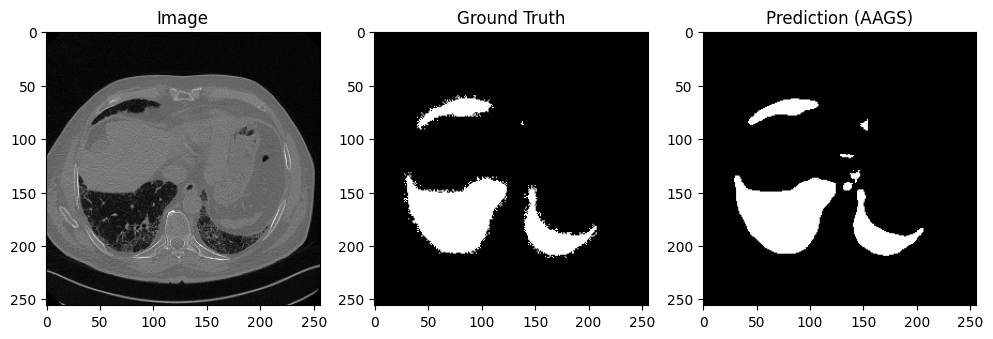

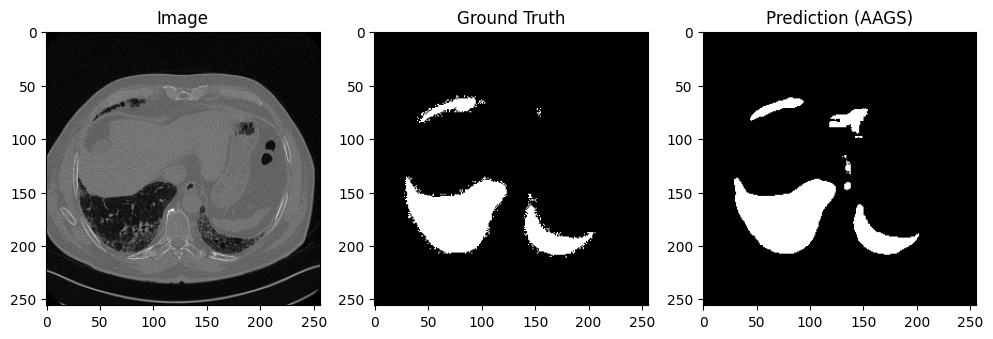

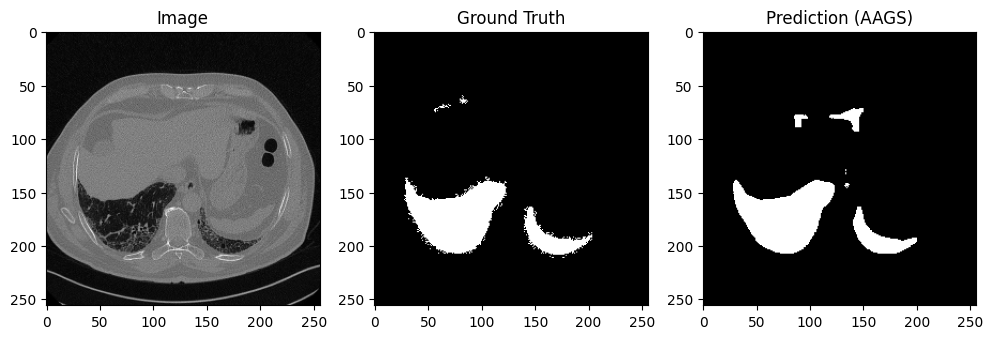

Comparison Results:
           mIoU         FLOPs  Inference Time
AAGS  0.792301  4.244118e+10        8.115443


In [6]:
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs, device, save_dir='/kaggle/working/'):
    model.train()
    # Create or initialize CSV for logging
    log_file = os.path.join(save_dir, 'training_log.csv')
    header = ['Epoch', 'Average_Loss', 'Average_Accuracy']
    if not os.path.exists(log_file):
        with open(log_file, 'w') as f:
            f.write(','.join(header) + '\n')

    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for image, mask in progress_bar:
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, mask)
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"NaN or Inf loss detected at Epoch {epoch+1}")
                break
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            
            # Compute accuracy (binary prediction with threshold 0.5)
            pred_binary = (output > 0.5).float()
            correct = (pred_binary == mask).sum().item()
            running_correct += correct
            total_samples += mask.numel()

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(correct / mask.numel())*100:.2f}%")

        avg_loss = running_loss / len(train_loader)
        avg_accuracy = (running_correct / total_samples) * 100  # Percentage
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.2f}%")

        # Log to CSV
        with open(log_file, 'a') as f:
            f.write(f"{epoch+1},{avg_loss:.4f},{avg_accuracy:.2f}\n")

        # Save model checkpoint
        checkpoint_path = os.path.join(save_dir, f'{model.__class__.__name__}_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    miou_metric = JaccardIndex(task="binary", threshold=0.5).to(device)
    total_time = 0
    with torch.no_grad():
        for img, mask in test_loader:
            img, mask = img.to(device), mask.to(device)
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            pred = model(img)
            end.record()
            torch.cuda.synchronize()
            total_time += start.elapsed_time(end)
            pred_binary = (pred > 0.5).float()
            mask_binary = mask.float()
            miou_metric.update(pred_binary, mask_binary)
    flops, _ = get_model_complexity_info(model, (1, 256, 256), as_strings=False)
    return {
        'mIoU': miou_metric.compute().item(),
        'FLOPs': flops,
        'Inference Time': total_time / len(test_loader.dataset)
    }

# Visualization function
def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (img, mask) in enumerate(loader):
            if i >= num_samples:
                break
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            plt.figure(figsize=(12, 4))
            plt.subplot(131); plt.imshow(img[0].squeeze().cpu(), cmap='gray'); plt.title('Image')
            plt.subplot(132); plt.imshow(mask[0].squeeze().cpu(), cmap='gray'); plt.title('Ground Truth')
            plt.subplot(133); plt.imshow(pred[0].squeeze().cpu() > 0.5, cmap='gray'); plt.title(f'Prediction ({model.__class__.__name__})')
            plt.show()

# Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = CombinedLoss(alpha=0.5) 
models = {
    # 'UNet': UNet(),
    # 'UNetCBAM': UNetCBAM(),
    'AAGS': AAGS()
}

base_dir = '/kaggle/input/chest-ct-segmentation'
image_dir = os.path.join(base_dir, 'images/images')
mask_dir = os.path.join(base_dir, 'masks/masks')
print(f"Image directory: {image_dir}, Mask directory: {mask_dir}")
print("Contents of image directory (sample):", os.listdir(image_dir)[:5])
print("Contents of mask directory (sample):", os.listdir(mask_dir)[:5])

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.nii'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.nii'))])

def get_base_id(filename):
    name = os.path.splitext(filename)[0]
    if 'mask' in name.lower():
        parts = name.split('_')
        try:
            mask_idx = parts.index('mask')
            base = '_'.join(parts[:mask_idx] + [parts[mask_idx + 1]])
        except (ValueError, IndexError):
            base = name
    else:
        base = name
    return base

image_bases = {get_base_id(f): f for f in image_files}
mask_bases = {get_base_id(f): f for f in mask_files}
total_common = len(set(image_bases.keys()).intersection(mask_bases.keys()))
print(f"Debug: Total common image-mask pairs: {total_common}")

train_end_idx = int(total_common * 0.8)
test_start_idx = train_end_idx
test_end_idx = total_common

train_dataset = ChestCTDataset(
    image_dir=os.path.join(image_dir),
    mask_dir=os.path.join(mask_dir),
    start_idx=0,
    end_idx=train_end_idx,
    transform=transform
)
test_dataset = ChestCTDataset(
    image_dir=os.path.join(image_dir),
    mask_dir=os.path.join(mask_dir),
    start_idx=test_start_idx,
    end_idx=test_end_idx,
    transform=None
)
print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)
print(f"Train loader length: {len(train_loader)}, Test loader length: {len(test_loader)}")

results = {}
for name, model in models.items():
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(train_loader), epochs=10)
    print(f"Training {name}...")
    train_model(model, train_loader, criterion, optimizer, scheduler, epochs=10, device=device)
    # Save final model
    final_model_path = os.path.join('/kaggle/working/', f'{name}_final.pth')
    torch.save(model.state_dict(), final_model_path)
    results[name] = evaluate_model(model, test_loader, device)
    visualize_predictions(model, test_loader, device)

df_results = pd.DataFrame(results).T
df_results.to_csv('/kaggle/working/chestct_comparison_results.csv')
print("Comparison Results:\n", df_results)